In [164]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier

In [165]:
WINDOW = 8 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX','WILLIAMS','OBV']
ROWS_TO_PREDICT = 32
# one day 16 rows of data

In [166]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-17 04:00:00-04:00,152.500000,155.990000,152.500000,155.000000,155.000000,0
2020-03-17 05:00:00-04:00,154.800000,154.990000,149.190000,149.820000,149.820000,0
2020-03-17 06:00:00-04:00,149.320000,149.800000,146.010000,148.600000,148.600000,0
2020-03-17 07:00:00-04:00,149.730000,152.000000,149.500000,151.000000,151.000000,0
2020-03-17 08:00:00-04:00,150.810000,152.400000,147.910000,149.500000,149.500000,0
...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,281.130005,281.559998,278.910004,279.130005,279.130005,2298570
2021-03-16 16:00:00-04:00,279.280000,279.290000,278.780000,279.185000,279.185000,1176864
2021-03-16 17:00:00-04:00,279.130000,281.480000,279.120000,281.125000,281.125000,0


In [167]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-17 04:00:00-04:00,152.500000,155.990000,152.500000,155.000000,155.000000,0
2020-03-17 05:00:00-04:00,154.800000,154.990000,149.190000,149.820000,149.820000,0
2020-03-17 06:00:00-04:00,149.320000,149.800000,146.010000,148.600000,148.600000,0
2020-03-17 07:00:00-04:00,149.730000,152.000000,149.500000,151.000000,151.000000,0
2020-03-17 08:00:00-04:00,150.810000,152.400000,147.910000,149.500000,149.500000,0
2020-03-17 09:00:00-04:00,149.430000,150.510000,148.060000,150.490000,150.490000,0
2020-03-17 09:30:00-04:00,150.259995,150.652206,140.000000,146.602707,146.602707,8866104
2020-03-17 10:30:00-04:00,146.589996,151.300003,143.869995,150.000000,150.000000,4780360
2020-03-17 11:30:00-04:00,150.000000,153.940002,148.740005,151.419998,151.419998,4152280


<AxesSubplot:xlabel='Datetime'>

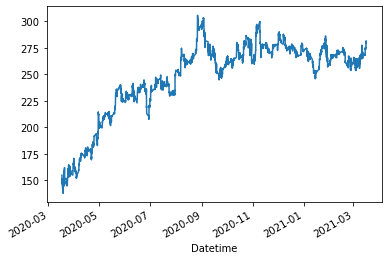

In [168]:
data['close'].plot()

In [169]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    # data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    # data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [170]:
data

,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,14 Williams %R,OBV,ema50,ema21,ema5
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
2020-03-17 05:00:00-04:00,149.820000,0,0.000000,-0.116218,-0.064566,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-66.666667,NaN,NaN,NaN,0.0,0.983172,0.983395,0.984527
2020-03-17 06:00:00-04:00,148.600000,0,0.000000,-0.185917,-0.114300,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-100.000000,NaN,NaN,NaN,0.0,0.983469,0.983837,0.985670
2020-03-17 07:00:00-04:00,151.000000,0,30.002679,-0.126410,-0.118402,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-14.253320,NaN,NaN,NaN,0.0,0.999519,0.999800,1.001077
2020-03-17 08:00:00-04:00,149.500000,0,24.961854,-0.151102,-0.128129,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-42.803094,NaN,NaN,NaN,0.0,0.991737,0.992070,0.993588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,61.112552,2.479560,2.147980,66.828247,6.966606e+09,2.034025,4.620005,50.293475,1.965299,95.578232,0.728547,1.173829,-33.171753,118244540.0,1.034373,1.019769,1.002939
2021-03-16 16:00:00-04:00,279.185000,1176864,61.242096,2.383395,2.195063,67.434319,6.966840e+09,2.042597,4.425000,47.555953,1.803165,67.867664,0.791931,1.175197,-32.565681,119421404.0,1.033876,1.019045,1.002613
2021-03-16 17:00:00-04:00,281.125000,0,65.596027,2.435648,2.243180,88.814051,6.966840e+09,2.122597,6.005000,47.555953,2.409748,89.948421,0.759392,1.180036,-11.185949,119421404.0,1.040223,1.024909,1.007970


In [171]:
data.columns

Index(['close', 'volume', '14 period RSI', 'MACD', 'SIGNAL',
       '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM', '14 period MFI',
       'ROC', '20 period CCI', 'VIm', 'VIp', '14 Williams %R', 'OBV', 'ema50',
       'ema21', 'ema5'],
      dtype='object')

In [172]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0

In [173]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,14 Williams %R,OBV,ema50,ema21,ema5,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,151.419998
2020-03-17 05:00:00-04:00,149.820000,0,0.000000,-0.116218,-0.064566,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-66.666667,NaN,NaN,NaN,0.0,0.983172,0.983395,0.984527,147.404999
2020-03-17 06:00:00-04:00,148.600000,0,0.000000,-0.185917,-0.114300,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-100.000000,NaN,NaN,NaN,0.0,0.983469,0.983837,0.985670,148.449997
2020-03-17 07:00:00-04:00,151.000000,0,30.002679,-0.126410,-0.118402,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-14.253320,NaN,NaN,NaN,0.0,0.999519,0.999800,1.001077,147.610001
2020-03-17 08:00:00-04:00,149.500000,0,24.961854,-0.151102,-0.128129,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-42.803094,NaN,NaN,NaN,0.0,0.991737,0.992070,0.993588,149.419998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,61.112552,2.479560,2.147980,66.828247,6.966606e+09,2.034025,4.620005,50.293475,1.965299,95.578232,0.728547,1.173829,-33.171753,118244540.0,1.034373,1.019769,1.002939,NaN
2021-03-16 16:00:00-04:00,279.185000,1176864,61.242096,2.383395,2.195063,67.434319,6.966840e+09,2.042597,4.425000,47.555953,1.803165,67.867664,0.791931,1.175197,-32.565681,119421404.0,1.033876,1.019045,1.002613,NaN
2021-03-16 17:00:00-04:00,281.125000,0,65.596027,2.435648,2.243180,88.814051,6.966840e+09,2.122597,6.005000,47.555953,2.409748,89.948421,0.759392,1.180036,-11.185949,119421404.0,1.040223,1.024909,1.007970,NaN


In [174]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,...,20 period CCI,VIm,VIp,14 Williams %R,OBV,ema50,ema21,ema5,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-17 04:00:00-04:00,155.000000,0,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,151.419998,-1
2020-03-17 05:00:00-04:00,149.820000,0,0.000000,-0.116218,-0.064566,NaN,0.000000e+00,NaN,NaN,NaN,...,-66.666667,NaN,NaN,NaN,0.0,0.983172,0.983395,0.984527,147.404999,-1
2020-03-17 06:00:00-04:00,148.600000,0,0.000000,-0.185917,-0.114300,NaN,0.000000e+00,NaN,NaN,NaN,...,-100.000000,NaN,NaN,NaN,0.0,0.983469,0.983837,0.985670,148.449997,0
2020-03-17 07:00:00-04:00,151.000000,0,30.002679,-0.126410,-0.118402,NaN,0.000000e+00,NaN,NaN,NaN,...,-14.253320,NaN,NaN,NaN,0.0,0.999519,0.999800,1.001077,147.610001,-1
2020-03-17 08:00:00-04:00,149.500000,0,24.961854,-0.151102,-0.128129,NaN,0.000000e+00,NaN,NaN,NaN,...,-42.803094,NaN,NaN,NaN,0.0,0.991737,0.992070,0.993588,149.419998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-16 15:30:00-04:00,279.130005,2298570,61.112552,2.479560,2.147980,66.828247,6.966606e+09,2.034025,4.620005,50.293475,...,95.578232,0.728547,1.173829,-33.171753,118244540.0,1.034373,1.019769,1.002939,NaN,0
2021-03-16 16:00:00-04:00,279.185000,1176864,61.242096,2.383395,2.195063,67.434319,6.966840e+09,2.042597,4.425000,47.555953,...,67.867664,0.791931,1.175197,-32.565681,119421404.0,1.033876,1.019045,1.002613,NaN,0
2021-03-16 17:00:00-04:00,281.125000,0,65.596027,2.435648,2.243180,88.814051,6.966840e+09,2.122597,6.005000,47.555953,...,89.948421,0.759392,1.180036,-11.185949,119421404.0,1.040223,1.024909,1.007970,NaN,0


In [175]:
# Class divide
data['class_column'].value_counts()

 1    1585
-1    1348
 0    1198
Name: class_column, dtype: int64

In [176]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [177]:
data['class_column'].value_counts()

 1    1562
-1    1303
 0    1163
Name: class_column, dtype: int64

In [178]:
train_set

,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,14 Williams %R,OBV,ema50,ema21,ema5,class_column
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-17 17:00:00-04:00,0,38.332583,-0.365993,-0.263845,47.364910,1.079931e+08,4.349794,-2.400000,51.283270,-1.009421,-60.815516,1.092615,0.894412,-52.635090,533917.0,0.985550,0.986446,0.990189,-1
2020-03-17 18:00:00-04:00,0,38.079794,-0.425936,-0.297202,50.143463,1.079931e+08,4.034794,-3.500000,51.283270,-2.655629,-82.383013,1.107458,0.937862,-49.856537,533917.0,0.985894,0.986930,0.991291,-1
2020-03-17 19:00:00-04:00,0,32.498589,-0.630977,-0.365495,31.061688,1.079931e+08,3.952651,-2.272707,51.283270,-3.458194,-149.181923,1.034516,0.953377,-68.938312,533917.0,0.970179,0.971569,0.977901,-1
2020-03-18 04:00:00-04:00,0,27.136495,-0.990216,-0.492732,18.820574,1.079931e+08,4.161937,-9.000000,51.283270,-6.306067,-285.903113,1.131635,0.851203,-81.179426,533917.0,0.951042,0.953037,0.962785,1
2020-03-18 05:00:00-04:00,0,28.659175,-1.228591,-0.642055,21.329984,1.079931e+08,3.905508,-10.019998,51.283270,-3.548848,-198.374119,1.140278,0.925380,-78.670016,533917.0,0.956507,0.959028,0.971279,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12 16:00:00-05:00,0,48.034488,-0.552934,-0.210354,53.759699,6.914330e+09,3.245255,-2.170000,44.742482,-0.134018,-49.958522,0.945415,0.770348,-46.240301,105250695.0,1.009054,0.999833,1.000173,0
2021-03-12 17:00:00-05:00,0,48.684626,-0.500503,-0.268384,55.322983,6.914330e+09,2.883826,-2.560000,44.742482,-0.037237,-34.391840,1.061674,0.977460,-44.677017,105250695.0,1.009575,1.000516,1.000735,1
2021-03-12 18:00:00-05:00,0,48.581276,-0.456113,-0.305930,55.076148,6.914330e+09,2.974319,-0.870000,44.742482,-0.743261,-51.767559,1.026897,0.929710,-44.923852,105250695.0,1.009275,1.000386,1.000519,1


In [179]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [180]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
# classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
# classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
# classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
# classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
# classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')
#
# classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
# classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
# classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
# classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
# classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy', n_jobs = -1)

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
# classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
# classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
# #
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
# classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
# classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
# classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [181]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [182]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  DecisionTreeClassifier 1
Score:  0.5
Calculate:  DecisionTreeClassifier 2
Score:  0.0625
Calculate:  DecisionTreeClassifier 3
Score:  0.5625
Calculate:  RandomForestClassifier 4
Score:  0.59375
Calculate:  RandomForestClassifier 5
Score:  0.59375
Calculate:  RandomForestClassifier 8
Score:  0.59375
Calculate:  GradientBoostingClassifier 1
Score:  0.375
Calculate:  GradientBoostingClassifier 5
Score:  0.3125
Calculate:  GradientBoostingClassifier 7
Score:  0.3125
Calculate:  GradientBoostingClassifier 9
Score:  0.40625
Calculate:  GradientBoostingClassifier 10
Score:  0.21875
+----+-------------------------------+------------+
|    | Classifier type               |   Accuracy |
|----+-------------------------------+------------|
|  0 | DecisionTreeClassifier 1      |    0.5     |
|  1 | DecisionTreeClassifier 2      |    0.0625  |
|  2 | DecisionTreeClassifier 3      |    0.5625  |
|  3 | RandomForestClassifier 4      |    0.59375 |
|  4 | RandomForestClassifier 5      |    

In [183]:
estimators=[
            ('GBC12', classifiers['RandomForestClassifier 8']),
            ('GBC11', classifiers['GradientBoostingClassifier 9']),
            ]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(x_train, y_train)
predicted = ensemble.predict(x_test)
score_ensemble = accuracy_score(y_test.values, predicted)
print('Score: ',  score_ensemble)

Score:  0.40625


In [184]:
print('Score: ',  score_ensemble)

Score:  0.40625


<AxesSubplot:>

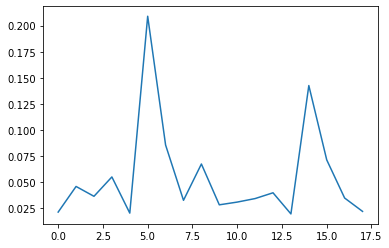

In [185]:

pd.Series(classifiers['GradientBoostingClassifier 9'].feature_importances_).plot()

In [186]:
classifiers['GradientBoostingClassifier 9'].feature_importances_

array([0.02152995, 0.04605542, 0.03663401, 0.05515647, 0.02055789,
       0.20891526, 0.08571015, 0.03279448, 0.06754051, 0.02847903,
       0.03109815, 0.03447251, 0.03999487, 0.01978169, 0.14260268,
       0.07148809, 0.03498983, 0.02219902])

In [187]:
x_test.columns



Index(['volume', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K',
       'MFV', '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI',
       'VIm', 'VIp', '14 Williams %R', 'OBV', 'ema50', 'ema21', 'ema5'],
      dtype='object')

In [188]:
x_test.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2021-03-15 06:00:00-04:00 to 2021-03-16 19:00:00-04:00
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   volume              32 non-null     int64  
 1   14 period RSI       32 non-null     float64
 2   MACD                32 non-null     float64
 3   SIGNAL              32 non-null     float64
 4   14 period STOCH %K  32 non-null     float64
 5   MFV                 32 non-null     float64
 6   14 period ATR       32 non-null     float64
 7   MOM                 32 non-null     float64
 8   14 period MFI       32 non-null     float64
 9   ROC                 32 non-null     float64
 10  20 period CCI       32 non-null     float64
 11  VIm                 32 non-null     float64
 12  VIp                 32 non-null     float64
 13  14 Williams %R      32 non-null     float64
 14  OBV                 32 non-null     float64
 15  ema50    